In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

import torch.nn.functional as F

from sklearn.manifold import TSNE

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [3]:
base_dir = '../Data_Generation/Data_files/labeled_points/'
base_fp = base_dir + '../points/sl2_Z_3s.csv'
test_fp = base_dir + 'sl2_Z_3s_test.csv'
train_fp = base_dir + 'sl2_Z_3s_train.csv'

In [187]:
MAX_REWARD = 100
STEP_PENALTY = -1

def get_reward(state: torch.Tensor) -> tuple[int, bool]:
    if state.equal(torch.eye(2)):
        return (MAX_REWARD, True)
    return (STEP_PENALTY, False)

### Network Architecture
$4\times1\to$ hidden layers $\to 4\times 1$

In [188]:
class DeepQModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepQModel, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(input_size, 128, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(128, 64, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(64, 16, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(16, output_size, dtype=torch.float64),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.stack(x)

In [189]:
MATRIX_SIZE = 4     # i.e. 2x2
NUM_GENERATORS = 4  # Number of generators in group (including inverses)

class DeepQAgent:
    def __init__(self, learning_rate: float, epsilon: float, epsilon_decay: float, 
                 min_epsilon: float, discount_factor: float, batch_size: int, memory_capacity: int):
        # Initialize main an target models and set weights to be equivalent
        self.mainModel = DeepQModel(MATRIX_SIZE, NUM_GENERATORS)
        self.targetModel = DeepQModel(MATRIX_SIZE, NUM_GENERATORS)
        
        # TODO: check if this works
        self.copy_main_to_target()

        # Initialize Hyperparameters
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.discount_factor = discount_factor
        self.batch_size = batch_size
        self.memory_capacity = memory_capacity

        # Optimization initialization
        self.optimizer = optim.Adam(self.mainModel.parameters(), lr=self.learning_rate)

        # Experience Replay Buffers and parameters
        self.memory = deque()
       
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        return self.mainModel.forward(x.flatten())

    def epsilon_greedy_search(self, state):
        if torch.rand(1) <= self.epsilon:
            return int(NUM_GENERATORS * torch.rand(1))
        x = torch.tensor(state)
        return self.mainModel.forward(x).argmax()

    def copy_main_to_target(self):
        self.targetModel.load_state_dict(self.mainModel.state_dict())

    def replay(self):
        # Ensure there is enough memory for a full batch
        if len(self.memory) <  self.batch_size:
            return

        # Random sample a batch_size's worth of memory
        minibatch = random.sample(self.memory, self.batch_size)

        # Vectorizing data
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.stack(states)
        next_states = torch.stack(next_states)
        #print("======= NEXT STATES ==========")
        actions = torch.stack(actions) # Stores matrices multiplied by NOT index
        rewards = torch.tensor(rewards, dtype=torch.float64)
        dones = torch.tensor(dones, dtype=torch.float64)
        
        # Bellman Equation: (Reward + discount_factor * state_prediction)
        target_predictions, _ = self.targetModel.forward(next_states.reshape(next_states.shape[0], 4)).max(dim=1)   # states
        # TODO: Add dones to the bellman update
        #print(target_predictions)

        bellmans = rewards + self.discount_factor * target_predictions
        next_q, _ = self.mainModel.forward(states.reshape(next_states.shape[0], 4)).max(dim=1)                      # next_states

        # print("========Important vals===========")
        # print(next_q.shape) # 100 x 1
        # print(rewards.shape)
        # print(bellmans.shape) # 100 x 100
        # print(target_predictions.shape) # 100 x 1


        # Calculate loss and perform optimization step
        loss = F.mse_loss(next_q, bellmans)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Perform Epsilon decay for each training step
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
        
    def remember(self, state, action, reward, next_state, done: bool):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.memory_capacity:
            self.memory.popleft()



In [190]:
class DeepQAgentTrainer: 
    def __init__(self, agent: DeepQAgent, actions: list[torch.Tensor], train_matrices: torch.Tensor, batch_size: int):
        self.agent = agent
        self.actions = actions
        self.train_matrices = train_matrices
        self.batch_size = batch_size
        self.total_episodes = 0
    
    def play(self, episodes: int, replay_periodicity: int, max_game_len: int):
        '''
        episodes - The number of episodes or 'games' played by the agent to train
        replay_periodicity - The number of episodes after which weights will be updated
        '''
        sample_idxs = torch.randint(0, self.train_matrices.shape[0], (episodes, ))
        for episode in torch.arange(0, episodes):
            print(f"Episode {episode+1}/{episodes}:")
            mat = self.train_matrices[sample_idxs[episode]]

            steps = 0
            done = False
            while steps < max_game_len and not done:
                pred = self.agent.predict(mat).argmax(dim=0)
                action = self.actions[pred]
                next_mat = torch.matmul(mat, action)
                reward, done = get_reward(mat)
                self.agent.remember(mat, action, reward, next_mat, done)

                # Update necessary vars for next iteration
                mat = next_mat
                steps += 1

            self.agent.replay()

In [49]:
# Load data
df = pd.read_csv(base_fp)
train_df = pd.read_csv(train_fp)
test_df = pd.read_csv(test_fp)

In [8]:
# All matrices
matrices_all = torch.tensor(df.values, dtype=torch.float64).reshape(100000, 2, 2)

# Training matrices and labels
train_data = torch.tensor(train_df.values, dtype=torch.float64)
labels_train = train_data[:,-1]
matrices_train = train_data[:,0:-2].reshape(train_data.shape[0], 2, 2)

# Testing matrices and labels
test_data = torch.tensor(test_df.values, dtype=torch.float64)
labels_test = test_data[:,-1]
matrices_test = test_data[:,0:-2].reshape(test_data.shape[0], 2, 2)

# Visualization vectors
basis_vec = torch.tensor([[1, 0]], dtype=torch.float64)
vecs_all = matrices_all.matmul(basis_vec.T)
vecs_train = matrices_train.matmul(basis_vec.T)
vecs_test = matrices_test.matmul(basis_vec.T)
x_train = vecs_train[:, 0]
x_test = vecs_test[:, 0]
y_train = vecs_train[:, 1]
y_test = vecs_test[:, 1]

# Training data masks to zoom plot
train_mask1 = x_train < 500
train_mask2 = x_train > -500
train_mask3 = y_train < 500
train_mask4 = y_train > -500
train_mask = train_mask1 & train_mask2 & train_mask3 & train_mask4

# Testing data mask to zoom plot
test_mask1 = x_test < 500
test_mask2 = x_test > -500
test_mask3 = y_test < 500
test_mask4 = y_test > -500
test_mask = test_mask1 & test_mask2 & test_mask3 & test_mask4

In [88]:
# # Plot data
# plt.scatter(vecs_all[:, 0], vecs_all[:, 1])
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('All Vectors')
# plt.grid(True)
# plt.show()

# plt.scatter(x_train, y_train, c=labels_train)
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Training Vectors (All)')
# plt.grid(True)
# plt.show()

# plt.scatter(x_train[train_mask], y_train[train_mask], c=labels_train[train_mask.flatten()])
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Training Vectors (Zoomed)')
# plt.grid(True)
# plt.show()

# plt.scatter(x_test, y_test, c=labels_test)
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Test Vectors (All)')
# plt.grid(True)
# plt.show()

# plt.scatter(x_test[test_mask], y_test[test_mask], c=labels_test[test_mask.flatten()])
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Test Vectors (Zoomed)')
# plt.grid(True)
# plt.show()

In [74]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
tsne_out = tsne.fit_transform(matrices_train.reshape(matrices_train.shape[0], 4).numpy())

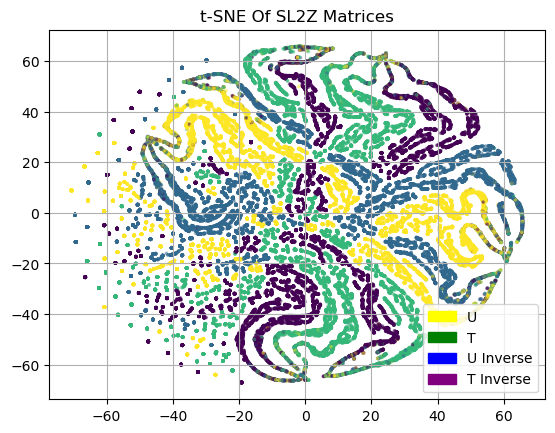

tensor(3., dtype=torch.float64)


In [92]:
plt.scatter(tsne_out[:,0], tsne_out[:,1], c=labels_train, cmap='viridis', s=3, alpha=.4)
plt.title('t-SNE Of SL2Z Matrices')
plt.legend(handles=[mpatches.Patch(color='yellow', label='U'),
                    mpatches.Patch(color='Green', label='T'),
                    mpatches.Patch(color='Blue', label='U Inverse'),
                    mpatches.Patch(color='Purple', label='T Inverse')])
plt.grid(True)
plt.show()
print(labels_train[0])

In [191]:
dqa = DeepQAgent(learning_rate=0.99, epsilon=1, epsilon_decay=0.999, min_epsilon=.3, discount_factor=.99, batch_size=100, memory_capacity=10_000)

In [192]:
U = torch.tensor([[1, 3], [0, 1]], dtype=torch.float64)
T = torch.tensor([[1, 0], [3, 1]], dtype=torch.float64)
U_INV = U.inverse()
T_INV = T.inverse()

generators = [U, T, U_INV, T_INV]

# matrices_train.reshape(matrices_train.shape[0], 4)
agent_trainer = DeepQAgentTrainer(dqa, generators, matrices_train, 100)

In [194]:
matrices_train.reshape(matrices_train.shape[0], 4)[0,:]
agent_trainer.play(100, 10, 50)

Episode 0/100:
Episode 1/100:
Episode 2/100:
Episode 3/100:
Episode 4/100:
Episode 5/100:
Episode 6/100:
Episode 7/100:
Episode 8/100:
Episode 9/100:
Episode 10/100:
Episode 11/100:
Episode 12/100:
Episode 13/100:
Episode 14/100:
Episode 15/100:
Episode 16/100:
Episode 17/100:
Episode 18/100:
Episode 19/100:
Episode 20/100:
Episode 21/100:
Episode 22/100:
Episode 23/100:
Episode 24/100:
Episode 25/100:
Episode 26/100:
Episode 27/100:
Episode 28/100:
Episode 29/100:
Episode 30/100:
Episode 31/100:
Episode 32/100:
Episode 33/100:
Episode 34/100:
Episode 35/100:
Episode 36/100:
Episode 37/100:
Episode 38/100:
Episode 39/100:
Episode 40/100:
Episode 41/100:
Episode 42/100:
Episode 43/100:
Episode 44/100:
Episode 45/100:
Episode 46/100:
Episode 47/100:
Episode 48/100:
Episode 49/100:
Episode 50/100:
Episode 51/100:
Episode 52/100:
Episode 53/100:
Episode 54/100:
Episode 55/100:
Episode 56/100:
Episode 57/100:
Episode 58/100:
Episode 59/100:
Episode 60/100:
Episode 61/100:
Episode 62/100:
Ep

In [195]:
dqa.predict(U.flatten())

tensor([-4.3763, -3.7672, 32.6060, -9.8682], dtype=torch.float64,
       grad_fn=<AddBackward0>)

In [198]:
q_vals, pred_action_idx = dqa.mainModel.forward(matrices_train.reshape(69999, 4)).max(dim=1, keepdim=True)

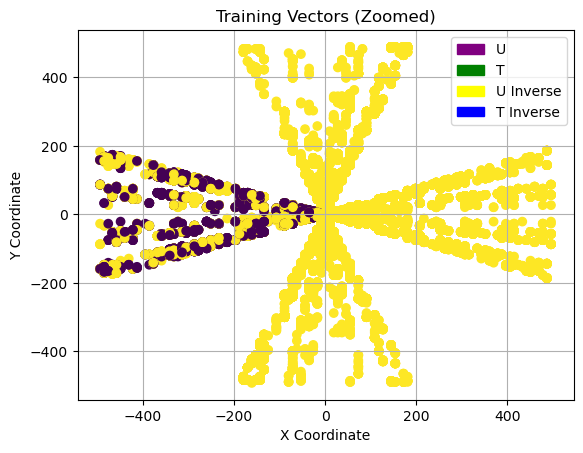

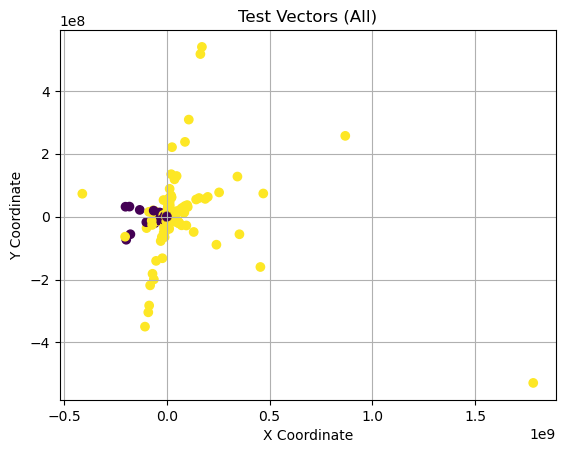

In [216]:
plt.scatter(x_train[train_mask], y_train[train_mask], c=pred_action_idx[train_mask.flatten()])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Training Vectors (Zoomed)')
plt.grid(True)
plt.legend(handles=[mpatches.Patch(color='Purple', label='U'),
                    mpatches.Patch(color='Green', label='T'),
                    mpatches.Patch(color='Yellow', label='U Inverse'),
                    mpatches.Patch(color='Blue', label='T Inverse')])
plt.show()

plt.scatter(x_train, y_train, c=pred_action_idx)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Test Vectors (All)')
plt.grid(True)
plt.show()